In [1]:
import pandas as pd

from dakkoai import (
    DakkoAIClient,
    DakkoRegistrationModel,
    DakkoSearch as DakkoSQL,
)

from functools import reduce

## Utility


In [2]:
def parse_args_complex(df: pd.DataFrame, names: str, args: str):
    # get first row of the column

    unique_names = df[names].unique()
    new_columns = [x.split(",") for x in unique_names]
    new_columns = reduce(lambda x, y: x + y, new_columns)

    df[new_columns] = None

    new_df = pd.DataFrame()

    for combo in unique_names:
        slice_df = df[df[names] == combo].copy()
        slice_df[combo.split(",")] = slice_df[args].str.split(";", expand=True)
        new_df = pd.concat([new_df, slice_df])

    new_df.drop(columns=[args, names], inplace=True)

    return new_df


# --------------------------- #


def parse_args_simple(data: pd.DataFrame, names: str, args: str):
    df = data.copy()
    new_names = df[names].values[0].split(",")
    df[new_names] = df[args].str.split(";", expand=True)

    df.drop(columns=[args, names], inplace=True)

    return df


# --------------------------- #


def parse_liquidity_df(df: pd.DataFrame) -> pd.DataFrame:
    ld_df = df.copy()
    liqiq = parse_args_complex(ld_df, "indexed_names", "indexed_args")
    liqiq = parse_args_complex(liqiq, "not_indexed_names", "not_indexed_args")
    liqiq["timestamp"] = pd.to_datetime(liqiq["timestamp"])

    # copy events with token id
    liqiq_id = liqiq[
        liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])
    ].copy()

    # copy events without token id
    liquiq_not_id = liqiq[
        ~liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])
    ].copy()

    # build mapping between positions and tick ranges
    tokenId_to_ticks = (
        (
            liqiq_id.drop(columns=["tickUpper", "tickLower"]).merge(
                liquiq_not_id[["transactionHash", "tickUpper", "tickLower"]],
                how="inner",
                on="transactionHash",
            )
        )[["tokenId", "tickUpper", "tickLower"]]
        .drop_duplicates()
        .reset_index(drop=True)
        .to_dict("records")
    )

    # remap
    tokenId_to_ticks_new = dict()

    for x in tokenId_to_ticks:
        tokenId_to_ticks_new[x["tokenId"]] = (x["tickUpper"], x["tickLower"])

    # apply for original df

    liqiq["tickUpper"] = liqiq.apply(
        lambda x: (
            tokenId_to_ticks_new[x["tokenId"]][0]
            if x["tokenId"] is not None
            else x["tickUpper"]
        ),
        axis=1,
    )
    liqiq["tickLower"] = liqiq.apply(
        lambda x: (
            tokenId_to_ticks_new[x["tokenId"]][1]
            if x["tokenId"] is not None
            else x["tickLower"]
        ),
        axis=1,
    )

    # rebuild liquidity column using all events now
    liqiq.liquidity = liqiq.apply(
        lambda x: float(x.liquidity) if x.liquidity is not None else float(x.amount),
        axis=1,
    )

    # convert to numeric
    for col in ["amount0", "amount1"]:
        liqiq[col] = liqiq[col].astype(float)

    liqiq.tickLower = liqiq.tickLower.astype(int)
    liqiq.tickUpper = liqiq.tickUpper.astype(int)

    # add multiplier for corresponding events
    for col in ["liquidity", "amount0", "amount1"]:
        liqiq[col] *= liqiq.event.apply(
            lambda x: -1 if x in ["DecreaseLiquidity", "Burn"] else 1
        )

    liqiq.drop_duplicates(["transactionHash", "liquidity"], inplace=True)

    liqiq.sort_values(by="timestamp", inplace=True)
    liqiq.reset_index(drop=True, inplace=True)

    return liqiq


# --------------------------- #


def get_liq_ticks(df: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    unique_ticks = sorted(set(df["tickLower"]).union(set(df["tickUpper"])))

    tick_liquidity = pd.DataFrame(unique_ticks, columns=["tick"]).set_index("tick")
    tick_liquidity["totalLiquidity"] = 0
    tick_liquidity["amount0locked"] = 0
    tick_liquidity["amount1locked"] = 0

    for _, row in df.iterrows():
        tick_liquidity.loc[
            row["tickLower"] : row["tickUpper"], "totalLiquidity"
        ] += row["liquidity"]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount0locked"] += row[
            "amount0"
        ]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount1locked"] += row[
            "amount1"
        ]

    tick_liquidity = tick_liquidity.reset_index()

    tick_liquidity["price"] = 1.0001 ** tick_liquidity["tick"] * 10 ** (dec1 - dec0)

    tick_liquidity["tick_width"] = tick_liquidity["tick"].diff().shift(-1).fillna(0)
    tick_liquidity["price_width"] = tick_liquidity["price"].diff().shift(-1).fillna(0)

    return tick_liquidity

## Dakko SDK Functions


In [3]:
def get_pool_events(pool: str, dakko_client: DakkoAIClient):
    pool = pool.lower()

    query = f"""
    SELECT DISTINCT * FROM (
        SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
        WHERE address = '{pool}'
    )
    INNER JOIN (
        SELECT DISTINCT indexed_names, not_indexed_names, signature 
        FROM dakko_poc.eth_static.event_registry_with_meta
    ) USING(signature)
    INNER JOIN (
        SELECT DISTINCT `from` as tx_from, transactionHash
        FROM dakko_poc.eth_bronze.raw_blocks_receipts
    ) USING(transactionHash)
    """

    query = DakkoSQL(query=query)
    evts = dakko_client.get_query_results(query).dataframe

    return evts


# --------------------------- #


def get_token_transfers(token: str, dakko_client: DakkoAIClient):
    token = token.lower()

    # get token transfers
    query = f"""
    SELECT DISTINCT * FROM (
        SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
        WHERE address = '{token}' AND event = 'Transfer'
    )
    INNER JOIN (
        SELECT indexed_names, not_indexed_names, signature 
        FROM dakko_poc.eth_static.event_registry_with_meta
    ) USING(signature)
    INNER JOIN (
        SELECT DISTINCT `from` as tx_from, transactionHash
        FROM dakko_poc.eth_bronze.raw_blocks_receipts
    ) USING(transactionHash)
    """
    query = DakkoSQL(query=query)
    evts = dakko_client.get_query_results(query).dataframe

    return evts


# --------------------------- #


def _parse_evt_args(data: pd.DataFrame):
    df = data.copy()
    df = parse_args_simple(df, "indexed_names", "indexed_args")
    df = parse_args_simple(df, "not_indexed_names", "not_indexed_args")

    return df


# --------------------------- #


def _post_abstract(data: pd.DataFrame):
    data = _parse_evt_args(data)
    data["timestamp"] = pd.to_datetime(data["timestamp"]).dt.tz_localize(None)

    return data


# --------------------------- #


def get_processed_swaps(data: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    df = data.copy()
    df = _post_abstract(df)

    df["amount0"] = df["amount0"].astype(float) / 10**dec0
    df["amount1"] = df["amount1"].astype(float) / 10**dec1
    df["price"] = (
        (df["sqrtPriceX96"].astype(float) / 2**96) ** 2 / 10 ** (dec0 - dec1)
    ).astype(float)

    df.drop(columns=["sqrtPriceX96"], inplace=True)

    return df


# --------------------------- #


def get_processed_mints(data: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    df = data.copy()
    df = _post_abstract(df)

    df["amount0"] = df["amount0"].astype(float) / 10**dec0
    df["amount1"] = df["amount1"].astype(float) / 10**dec1

    df["tickUpper"] = df["tickUpper"].astype(int)
    df["tickLower"] = df["tickLower"].astype(int)
    df["amount"] = df["amount"].astype(float)

    return df


# --------------------------- #


def postprocess_pool_events(data: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    df = data.copy()

    swaps = df[df.event == "Swap"].copy().reset_index(drop=True)
    collects = df[df.event == "Collect"].copy().reset_index(drop=True)
    burns = df[df.event == "Burn"].copy().reset_index(drop=True)
    mints = df[df.event == "Mint"].copy().reset_index(drop=True)

    swaps = get_processed_swaps(swaps, dec0=dec0, dec1=dec1)
    collects = _post_abstract(collects)
    burns = get_processed_mints(burns)
    mints = get_processed_mints(mints)

    return swaps, collects, burns, mints


# --------------------------- #

## Main body


In [4]:
dakko_client = DakkoAIClient()
user_data = DakkoRegistrationModel(
    email="user@example.com", first_name="John", last_name="Doe", user_name="johndoe"
)

dakko_client.register(user_data)
dakko_client.get_access_token()

{'status': 'ok'}

Query used for that:

```sql
SELECT DISTINCT * FROM (
    SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
    WHERE address = '{pool}'
)
INNER JOIN (
    SELECT DISTINCT indexed_names, not_indexed_names, signature
    FROM dakko_poc.eth_static.event_registry_with_meta
) USING(signature)
INNER JOIN (
    SELECT DISTINCT `from` as tx_from, transactionHash
    FROM dakko_poc.eth_bronze.raw_blocks_receipts
) USING(transactionHash)
```


In [5]:
# LINK/WETH pool address
LINK_WETH = "0xa6Cc3C2531FdaA6Ae1A3CA84c2855806728693e8"
LINK_WETH = LINK_WETH.lower()

link_weth_evts = get_pool_events(LINK_WETH, dakko_client)

In [6]:
LINK_WETH_SUSHI = "0xC40D16476380e4037e6b1A2594cAF6a6cc8Da967"
LINK_WETH_SUSHI = LINK_WETH_SUSHI.lower()

link_weth_sushi_evts = get_pool_events(LINK_WETH_SUSHI, dakko_client)

In [8]:
LINK = "0x514910771AF9Ca656af840dff83E8264EcF986CA"
LINK = LINK.lower()

link_raw_transfers = get_token_transfers(LINK, dakko_client)

In [11]:
swaps_uni, collects_uni, burns_uni, mints_uni = postprocess_pool_events(link_weth_evts)
# swaps_sushi, collects_sushi, burns_sushi, mints_sushi = postprocess_pool_events(
#     link_weth_sushi_evts
# )

swaps_uni.set_index("timestamp", inplace=True)
# swaps_sushi.set_index("timestamp", inplace=True)

# build ohlcv series
swaps_uni_1h = swaps_uni.resample("1H").agg(
    {
        "amount0": "sum",
        "amount1": "sum",
        "price": "ohlc",
    }
)

swaps_uni_vol = swaps_uni.resample("6H").agg(
    {
        "amount0": "sum",
        "amount1": "sum",
        "price": "ohlc",
    }
)

# swaps_sushi_1h = swaps_sushi.resample("1H").agg(
#     {
#         "amount0": "sum",
#         "amount1": "sum",
#         "price": "ohlc",
#     }
# )

# swaps_sushi_vol = swaps_sushi.resample("6H").agg(
#     {
#         "amount0": "sum",
#         "amount1": "sum",
#         "price": "ohlc",
#     }
# )

In [12]:
swaps_uni_1h[["amount0", "amount1"]].fillna(0, inplace=True)
swaps_uni_1h.fillna(method="ffill", inplace=True)
swaps_uni_1h.columns = swaps_uni_1h.columns.droplevel(0)

swaps_uni_vol[["amount0", "amount1"]].fillna(0, inplace=True)
swaps_uni_vol.fillna(method="ffill", inplace=True)
swaps_uni_vol.columns = swaps_uni_vol.columns.droplevel(0)

/tmp/ipykernel_604088/3679711351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps_uni_1h[["amount0", "amount1"]].fillna(0, inplace=True)
/tmp/ipykernel_604088/3679711351.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps_uni_vol[["amount0", "amount1"]].fillna(0, inplace=True)


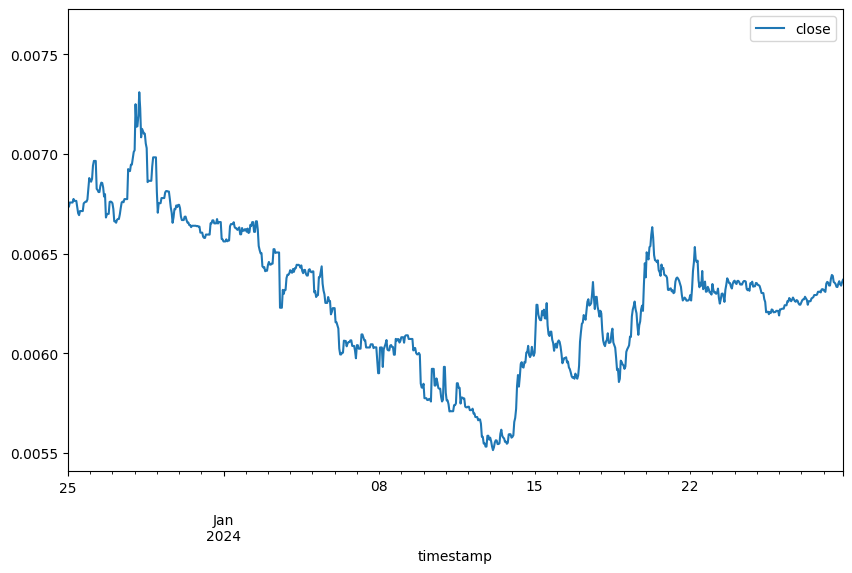

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(10, 6))
start_dt = datetime(2023, 12, 25)
end_dt = datetime(2024, 1, 30)

swaps_uni_1h.plot(y="close", ax=ax)
_ = ax.set_xlim(
    max(start_dt, swaps_uni_1h.index.min()), min(end_dt, swaps_uni_1h.index.max())
)

In [14]:
def temp_plot_liq_changes(mints, burns, start_dt, end_dt):
    import matplotlib.pyplot as plt

    mints_se = mints[
        (mints["timestamp"] >= start_dt) & (mints["timestamp"] <= end_dt)
    ].copy()
    burns_se = burns[
        (burns["timestamp"] >= start_dt) & (burns["timestamp"] <= end_dt)
    ].copy()
    mints_liq = mints_se.copy()
    burns_liq = burns_se.copy()
    mints_liq["liquidity"] = mints_liq["amount"].astype(float)
    burns_liq["liquidity"] = -burns_liq["amount"].astype(float)

    all_liq = pd.concat([mints_liq, burns_liq], ignore_index=True).reset_index(
        drop=True
    )

    ticks_changes = get_liq_ticks(all_liq)
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(
        ticks_changes["price"],
        ticks_changes["totalLiquidity"],
        width=ticks_changes["price_width"],
        align="edge",
        color="violet",
        label="Liquidity",
    )

    ax.set_ylabel("Liquidity diff", labelpad=15)
    ax.set_xlabel("Price", labelpad=15)

    ax.set_xlim(5e-3, 9e-3)


def temp_get_participants(mints, burns, start_dt, end_dt):
    mints_se = mints[
        (mints["timestamp"] >= start_dt) & (mints["timestamp"] <= end_dt)
    ].copy()
    burns_se = burns[
        (burns["timestamp"] >= start_dt) & (burns["timestamp"] <= end_dt)
    ].copy()
    mints_liq = mints_se.copy()
    burns_liq = burns_se.copy()
    mints_liq["liquidity"] = mints_liq["amount"].astype(float)
    burns_liq["liquidity"] = -burns_liq["amount"].astype(float)

    all_liq = pd.concat([mints_liq, burns_liq], ignore_index=True).reset_index(
        drop=True
    )

    all_liq = all_liq[["tx_from", "liquidity", "tickUpper", "tickLower"]].copy()
    all_liq = (
        all_liq.groupby(["tx_from", "tickUpper", "tickLower"])
        .agg({"liquidity": "sum"})
        .reset_index()
        .sort_values(by="liquidity", ascending=False)
        .reset_index(drop=True)
    )

    return all_liq

Seed significant liquidity drainage between 2023-12-28 and 2023-12-29


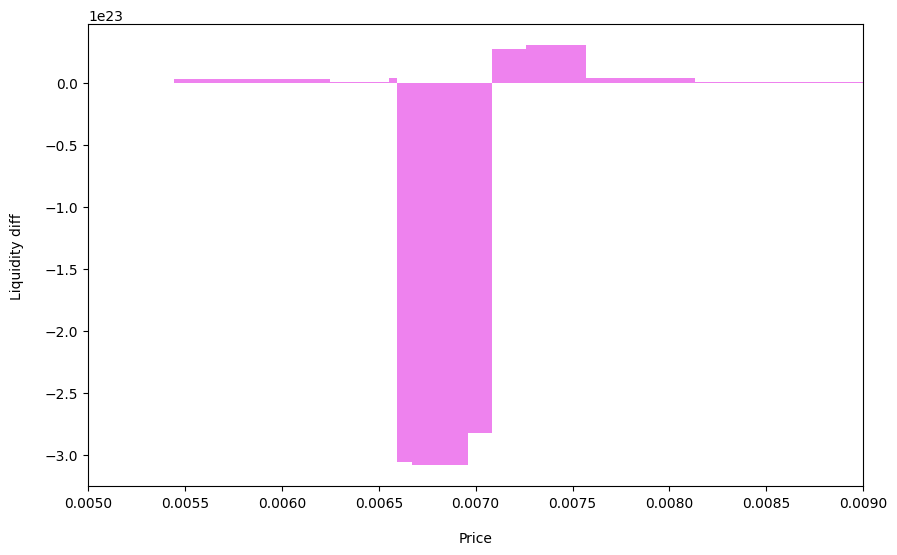

In [15]:
start_dt = datetime(2023, 12, 28)
end_dt = datetime(2023, 12, 30)

temp_plot_liq_changes(mints_uni, burns_uni, start_dt, end_dt)

pa = temp_get_participants(mints_uni, burns_uni, start_dt, end_dt)
pa_size = 1
pos_pa = pa.sort_values(by="liquidity", ascending=False).head(pa_size).tx_from.tolist()
neg_pa = pa.sort_values(by="liquidity", ascending=True).head(pa_size).tx_from.tolist()

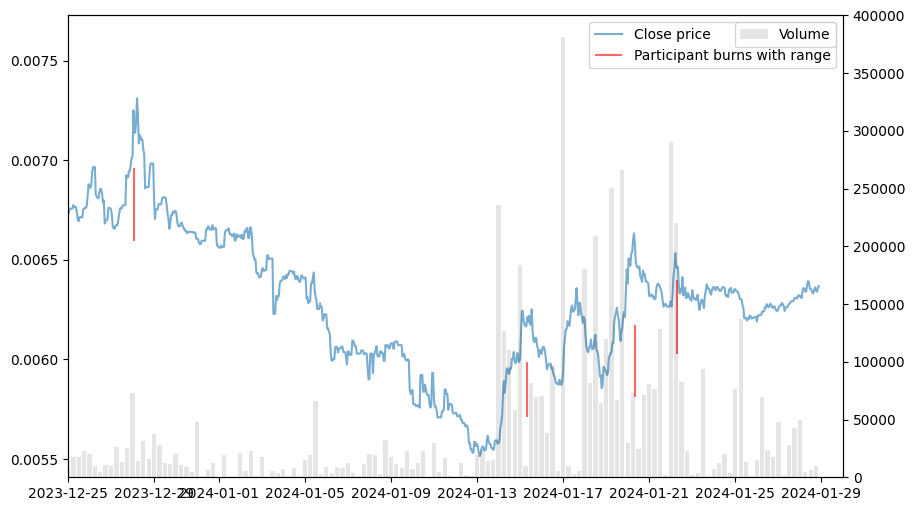

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(10, 6))
start_dt = datetime(2023, 12, 25)
end_dt = datetime(2024, 1, 30)

ax.plot(
    swaps_uni_1h.index,
    swaps_uni_1h["close"],
    alpha=0.6,
    label="Close price",
)

ax2 = ax.twinx()

ax2.bar(
    swaps_uni_vol.index,
    abs(swaps_uni_vol["amount0"]),
    color="black",
    alpha=0.1,
    label="Volume",
    width=0.2,
)
# swaps_1h.plot(y="amount0", ax=ax2, alpha=0.1, color="black", zorder=-10, label="")

# maxdt = max(start_dt, swaps_1h.index.min())
# mindt = min(end_dt, swaps_1h.index.max())

# maxdt = pd.to_datetime(maxdt)
# mindt = pd.to_datetime(mindt)

_ = ax.set_xlim(start_dt, end_dt)
_ = ax2.set_xlim(start_dt, end_dt)

participant_burns = burns_uni[burns_uni.tx_from.isin(neg_pa)].copy()

participant_burns["priceLower"] = participant_burns["tickLower"].apply(
    lambda x: 1.0001**x * 10 ** (18 - 18)
)
participant_burns["priceUpper"] = participant_burns["tickUpper"].apply(
    lambda x: 1.0001**x * 10 ** (18 - 18)
)

ax.vlines(
    x=participant_burns["timestamp"].values,
    ymin=participant_burns["priceLower"],
    ymax=participant_burns["priceUpper"],
    alpha=0.6,
    color="red",
    label="Participant burns with range",
)

ax2.legend(loc="upper right")
ax.legend(loc="upper right")

In [48]:
participant_burns

,transactionHash,signature,address,logIndex,event,timestamp,tx_from,owner,tickLower,tickUpper,amount,amount0,amount1,priceLower,priceUpper
214,0x03955c3099fe697805e4accc9323b3123400ff384dd0...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x160,Burn,2024-01-22 07:05:35,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-51120,-50520,2.611788e+23,0.0,617.400000,0.006026,0.006398
218,0x678f9df1a01bb074146ee3684cc42994cf16476c6f49...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x8c,Burn,2024-01-20 07:47:11,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-51480,-50880,2.613352e+23,0.0,606.750000,0.005813,0.006172
320,0x45e5a58bdbd0675aa1f2dfa813e78d67b6da20b8fef9...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x154,Burn,2023-12-23 16:17:47,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-50400,-49860,3.094254e+23,0.0,681.406958,0.006475,0.006835
361,0x7068102b26afd110649cb210f10983168ff2d1951f5d...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x6d,Burn,2023-12-22 00:22:47,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-50520,-49860,2.501502e+23,0.0,671.282511,0.006398,0.006835
393,0xb8aae81747e5f2a46d8e47ff0770ec2cd747698eef41...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xd5,Burn,2024-01-15 07:18:11,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-51660,-51180,3.262721e+23,0.0,598.776316,0.005709,0.005990
538,0x3e9004cd7076c8da23ea228de1aed52634bd7a5db43a...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xb5,Burn,2023-12-28 01:40:23,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-50220,-49680,3.090623e+23,0.0,686.760000,0.006593,0.006959


Next steps:

1. Check where the funds went, i.e. identify which smart contracts and wallets the main cause wallet interacted with
2. Show what happened
3. Show chain logic (???)


In [24]:
ts = int(participant_burns["timestamp"].min().timestamp())
neg_pa_join = ", ".join([f"'{x}'" for x in neg_pa])

query = f"""
    SELECT DISTINCT * FROM (
        SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
        WHERE timestamp >= FROM_UNIXTIME({ts})
    )
    INNER JOIN (
        SELECT DISTINCT indexed_names, not_indexed_names, signature 
        FROM dakko_poc.eth_static.event_registry_with_meta
    ) USING(signature)
    INNER JOIN (
        SELECT DISTINCT `from` as tx_from, transactionHash
        FROM dakko_poc.eth_bronze.raw_blocks_receipts
        WHERE `from` IN ({neg_pa_join})
    ) USING(transactionHash)
    """

print(query)

query = DakkoSQL(query=query)
evts = dakko_client.get_query_results(query).dataframe


    SELECT DISTINCT * FROM (
        SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
        WHERE timestamp >= FROM_UNIXTIME(1703204567)
    )
    INNER JOIN (
        SELECT DISTINCT indexed_names, not_indexed_names, signature 
        FROM dakko_poc.eth_static.event_registry_with_meta
    ) USING(signature)
    INNER JOIN (
        SELECT DISTINCT `from` as tx_from, transactionHash
        FROM dakko_poc.eth_bronze.raw_blocks_receipts
        WHERE `from` IN ('0xfa4c635e555d7f5464e24e48da6887cf74cc2f15')
    ) USING(transactionHash)
    


In [44]:
weth_events = evts[evts.address == "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"].copy()
weth_transfers = weth_events[
    (weth_events.event == "Transfer")
    & (~weth_events.not_indexed_args.isnull())
    & (weth_events.not_indexed_names == "value")
].copy()

weth_transfers = parse_args_simple(weth_transfers, "indexed_names", "indexed_args")
weth_transfers = parse_args_simple(
    weth_transfers, "not_indexed_names", "not_indexed_args"
)

weth_transfers["value"] = weth_transfers["value"].astype(float) / 10**18

weth_transfers.sort_values(by="timestamp", inplace=True)
weth_transfers.reset_index(drop=True, inplace=True)

In [46]:
weth_transfers

,transactionHash,signature,address,logIndex,event,timestamp,tx_from,from,to,value
0,0x7068102b26afd110649cb210f10983168ff2d1951f5d...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x70,Transfer,2023-12-22T00:22:47+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xc36442b4a4522e871399cd717abdd847ab11fe88,679.330780
1,0xd1d491c3688d5f78ec3636df7844b5a10db404113111...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x191,Transfer,2023-12-22T02:01:11+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,680.180000
2,0x45e5a58bdbd0675aa1f2dfa813e78d67b6da20b8fef9...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x157,Transfer,2023-12-23T16:17:47+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xc36442b4a4522e871399cd717abdd847ab11fe88,685.527194
3,0x3e9004cd7076c8da23ea228de1aed52634bd7a5db43a...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xb8,Transfer,2023-12-28T01:40:23+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xc36442b4a4522e871399cd717abdd847ab11fe88,687.598703
4,0xb8aae81747e5f2a46d8e47ff0770ec2cd747698eef41...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd8,Transfer,2024-01-15T07:18:11+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xc36442b4a4522e871399cd717abdd847ab11fe88,602.392755
5,0xf3ad29db3322f2510205fb53ef0af9cdf0f5fda17c48...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6e,Transfer,2024-01-15T07:19:59+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,606.750000
6,0x678f9df1a01bb074146ee3684cc42994cf16476c6f49...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x8f,Transfer,2024-01-20T07:47:11+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xc36442b4a4522e871399cd717abdd847ab11fe88,617.427873
7,0x484ad8b90d852120ea87f315afba19f89ea0c6d776a7...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe6,Transfer,2024-01-20T16:25:59+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,617.400000
8,0x03955c3099fe697805e4accc9323b3123400ff384dd0...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x163,Transfer,2024-01-22T07:05:35+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xc36442b4a4522e871399cd717abdd847ab11fe88,619.223656
9,0xb1d5e074a941d4c9f09d950e62430ef1550cee766dd8...,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x107,Transfer,2024-01-22T07:08:11+00:00,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,619.200000


In [49]:
weth_transfers.transactionHash.tolist()

['0x7068102b26afd110649cb210f10983168ff2d1951f5d3c453cd0e22bf30b0867',
 '0xd1d491c3688d5f78ec3636df7844b5a10db4041131119545299160405e78868c',
 '0x45e5a58bdbd0675aa1f2dfa813e78d67b6da20b8fef9f53c7b91c03900979143',
 '0x3e9004cd7076c8da23ea228de1aed52634bd7a5db43a26c754a16b432a8ae380',
 '0xb8aae81747e5f2a46d8e47ff0770ec2cd747698eef41900be73b379672fc4c6b',
 '0xf3ad29db3322f2510205fb53ef0af9cdf0f5fda17c48dd2663ecf593968ec7b5',
 '0x678f9df1a01bb074146ee3684cc42994cf16476c6f49107a2af24641c162f69e',
 '0x484ad8b90d852120ea87f315afba19f89ea0c6d776a76dfa453b4d795189adc7',
 '0x03955c3099fe697805e4accc9323b3123400ff384dd02766ede1bbe9c32322f3',
 '0xb1d5e074a941d4c9f09d950e62430ef1550cee766dd842768c9855f4e6ad7756']

Observe whale liquidity provider


In [216]:
neg_pa

['0xfa4c635e555d7f5464e24e48da6887cf74cc2f15']